## Problem 3 - Xianghui Gu

### 3.1 Preprocess the data

In [37]:
%matplotlib inline

In [5]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

- import images from folder

In [56]:
from os import walk

image_names = []
for (dirpath, dirnames, filenames) in walk('q3/'):
    image_names.extend(filenames)

image_names = image_names[1:]

- loop to convert figures to vectors ( autoencoder and svd needs further modification in next few chapters)

- rgb and hsv histograms are generated here !!! (3.2.3 and 3.2.4)

In [140]:
from skimage import io
from skimage.color import rgb2hsv
from skimage.transform import resize
from time import time

stime = time()
image_num = len(image_names)
fail_id = []

enc_mat = np.empty([image_num, 64, 64, 3])
svd_mat = np.empty([image_num, 64*64*3])
rgb_hists = np.empty([image_num, 256*3])
hsv_hists = np.empty([image_num, 256*3])

for i in range(image_num):
    sample = io.imread('q3/' + image_names[i])
    
    # resize the image to 64*64
    small = resize(sample, (64, 64, 3))
    
    ### 1. autoencoder
    enc_mat[i,:,:,:] = small
    
    ### 2. SVD
    svd_mat[i,:] = small.flatten('F')
    
    try:
        # count how many pixels per layer
        length, width, height = sample.shape
        area = length * width

        ### 3. rgb
        rgb_hist = np.array([])
        for path in range(3):
            hist, bins = np.histogram(sample[:,:,path],256,[0,256])
            rgb_hist = np.append(rgb_hist, hist)
        rgb_hists[i,:] = rgb_hist / area

        ### 4. hsv
        hsv = rgb2hsv(sample)
        hsv_hist = np.array([])
        for path in range(3):
            hist, bins = np.histogram(hsv[:,:,path],256,[0,1])
            hsv_hist = np.append(hsv_hist, hist)
        hsv_hists[i,:] = hsv_hist / area 
    except:
        print("image ",i," fails")
        fail_id.append(i)
        continue
etime = time()
print((etime-stime)/60)

image  468  fails
image  2243  fails
image  2377  fails
image  4115  fails
image  4642  fails
image  4745  fails
image  5349  fails
image  5909  fails
image  6433  fails
image  6515  fails
image  6909  fails
image  6979  fails
image  7070  fails
image  7350  fails
14.11398261388143


- clean black and white images

In [184]:
person = [1]*1242
animal = [2]*1571
plant = [3]*1271
sport = [4]*1888
geo = [5]*1808
fungus = [6]*1207
tag = person + animal + plant + sport + geo + fungus
len(tag)

8987

In [185]:
colorful = list(set(range(len(tag)))- set(fail_id))
tag_tot = np.array(tag)

### 3.2 Two detailed methods to reduct dimension

- divide 80/20 train/test split
(tag is the classification, index is the original index before split)

In [196]:
from sklearn.cross_validation import train_test_split
enc_train, enc_test, svd_train, svd_test, rgb_train, rgb_test, hsv_train, hsv_test, tag_train, tag_test, index_train, index_test \
                   = train_test_split(enc_mat[colorful],
                   svd_mat[colorful], rgb_hists[colorful], hsv_hists[colorful],
                   tag_tot[colorful], colorful, test_size=0.20, random_state=0)


#### 3.2.1 Autoencoder

- normalize the encoder matrix and adjust the type

In [209]:
enc_train_normal = enc_train.astype('float32') / 255.
enc_test_normal = enc_test.astype('float32') / 255.

- train the autoencoder

In [213]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

history = autoencoder.fit(enc_train_normal, enc_train_normal,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(enc_test_normal, enc_test_normal))

Train on 7178 samples, validate on 1795 samples
Epoch 1/10
7178/7178 [==============================] - 61s - loss: 0.2901 - mean_squared_error: 0.0959 - val_loss: 0.0183 - val_mean_squared_error: 4.1109e-04
Epoch 2/10
7178/7178 [==============================] - 62s - loss: 0.0180 - mean_squared_error: 3.2500e-04 - val_loss: 0.0178 - val_mean_squared_error: 2.8433e-04
Epoch 3/10
7178/7178 [==============================] - 66s - loss: 0.0176 - mean_squared_error: 2.6570e-04 - val_loss: 0.0173 - val_mean_squared_error: 2.4823e-04
Epoch 4/10
7178/7178 [==============================] - 60s - loss: 0.0170 - mean_squared_error: 2.2289e-04 - val_loss: 0.0166 - val_mean_squared_error: 1.9646e-04
Epoch 5/10
7178/7178 [==============================] - 60s - loss: 0.0162 - mean_squared_error: 1.7007e-04 - val_loss: 0.0158 - val_mean_squared_error: 1.4597e-04
Epoch 6/10
7178/7178 [==============================] - 60s - loss: 0.0154 - mean_squared_error: 1.2114e-04 - val_loss: 0.0150 - val_mea

- predict both datasets for further comparison

In [307]:
output = Model(input_img, encoded)
enc_test_pred = output.predict(enc_test_normal)
enc_train_pred = output.predict(enc_train_normal)

#### 3.2.2 SVD

First, we try k = 50 to plot the singular value trend.

In [224]:
from scipy.sparse.linalg import svds
u_red, s_red, v_red = svds(svd_train, k = 50)

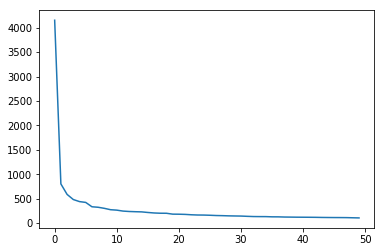

In [226]:
plt.plot(s_red[::-1])

As can be seen from the figure, the singular value tends to be stable after k = 40. Hence, we select 40.

In [394]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 40)
svd_train_pred = svd.fit_transform(svd_train)
svd_test_pred = svd.transform(svd_test)

#### 3.2.3 RGB

See 3.1

#### 3.2.4 HSV

See 3.1

### 3.3 Classification

- distance function

In [267]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import euclidean_distances
def pearsonr_distances(X, Y):
    left = len(X)
    top = len(Y)
    result = np.empty([left, top])
    for i in range(left):
        for j in range(top):
            result[i][j] = pearsonr(X[i],Y[j])[0] ### pearsonr returns (coef, p-value)
    return result

- select smallest for euclidean_distances

In [286]:
def smallest(k, vec):
    ind = np.argpartition(vec, k)[:k]
    return ind

- select largest for pearsonr_distances

In [285]:
def largest(k, vec):
    ind = np.argpartition(vec, -k)[-k:]
    return ind

- KNN (k = 5) Vote

In [353]:
from scipy.stats import mode
### dist:'e' or 'p'
def KNNVote(k, distances, dist):
    if dist!='e' and dist!='p':
        print('error: select e or p in dist')
        return
    
    guess = []
    num_row, num_col = distances.shape
    
    for i in range(num_row):
        
        if dist == 'e':
            cand = smallest(k,distances[i])
        else:
            cand = largest(k,distances[i])
        
        vote = mode(tag_train[cand])[0][0]
        guess.append(vote)
    
    return guess

- compute accuracy

In [357]:
def acc(y_true, y_pred):
    count = 0
    length = len(y_true)
    for i in range(length):
        if y_true[i] == y_pred[i]:
            count += 1
    return count/float(length)

In [316]:
from sklearn.metrics import confusion_matrix

#### 3.3.1 autoencoder

In [309]:
x1 = enc_test_pred.reshape(len(enc_test_pred),np.prod((enc_test_pred).shape[1:]))
y1 = enc_train_pred.reshape(len(enc_train_pred),np.prod((enc_test_pred).shape[1:]))

- compute distances

In [310]:
ed_1 = euclidean_distances(x1,y1)

In [349]:
pc_1 = pearsonr_distances(x1,y1)

- Vote

In [354]:
ed_guess_1 = KNNVote(5, ed_1, 'e')
pc_guess_1 = KNNVote(5, pc_1, 'p')

In [379]:
print("autoencoder","and euclidean accuracy: %.2f"%acc(tag_test,ed_guess_1))

autoencoder and euclidean accuracy: 0.32


In [368]:
print(confusion_matrix(tag_test, ed_guess_1, sample_weight=None))

[[ 77  61  24  17  62  11]
 [ 57 101  32  26  82   7]
 [ 83  56  45   8  32  22]
 [ 78 102  28  72  68  13]
 [ 39  59  24  13 235  13]
 [102  44  39   2  22  39]]


In [380]:
print("autoencoder","and pearson accuracy: %.2f"%acc(tag_test,pc_guess_1))

autoencoder and pearson accuracy: 0.36


In [367]:
print(confusion_matrix(tag_test, pc_guess_1, sample_weight=None))

[[ 52  58  26  21  82  13]
 [ 18 115  23  23 108  18]
 [ 13  71  54   9  75  24]
 [ 22 105  23  88 111  12]
 [  9  51  11  16 288   8]
 [ 16  62  32   4  85  49]]


#### 3.3.2 SVD

In [396]:
x2 = svd_test_pred
y2 = svd_train_pred

- compute distances

In [397]:
ed_2 = euclidean_distances(x2,y2)

In [398]:
pc_2 = pearsonr_distances(x2,y2)

- Vote

In [399]:
ed_guess_2 = KNNVote(5, ed_2, 'e')
pc_guess_2 = KNNVote(5, pc_2, 'p')

In [407]:
print("SVD","and euclidean accuracy: %.2f"%acc(tag_test,ed_guess_2))

SVD and euclidean accuracy: 0.41


In [402]:
print(confusion_matrix(tag_test, ed_guess_2, sample_weight=None))

[[ 70  48  22  44  55  13]
 [ 25  74  57  62  60  27]
 [ 11  37 119  26  28  25]
 [ 18  60  38 156  73  16]
 [ 12  45  25  46 241  14]
 [ 22  36  60  24  34  72]]


In [406]:
print("SVD","and pearson accuracy: %.2f"%acc(tag_test,pc_guess_2))

SVD and pearson accuracy: 0.40


In [403]:
print(confusion_matrix(tag_test, pc_guess_2, sample_weight=None))

[[ 65  56  18  36  61  16]
 [ 32  81  52  63  54  23]
 [ 10  47 116  15  38  20]
 [ 26  58  26 141  97  13]
 [ 21  34  14  45 255  14]
 [ 14  52  56  17  41  68]]


#### 3.3.3 RGB

In [369]:
x3 = rgb_test
y3 = rgb_train

- compute distances

In [370]:
ed_3 = euclidean_distances(x3,y3)

In [371]:
pc_3 = pearsonr_distances(x3,y3)

- Vote

In [372]:
ed_guess_3 = KNNVote(5, ed_3, 'e')
pc_guess_3 = KNNVote(5, pc_3, 'p')

In [383]:
print("RGB","and euclidean accuracy: %.2f"%acc(ed_guess_3, tag_test))

RGB and euclidean accuracy: 0.37


In [381]:
print(confusion_matrix(tag_test, ed_guess_3, sample_weight=None))

[[ 88  56  14  14  19  61]
 [ 36 113  38  16  40  62]
 [ 18  41  98  12  24  53]
 [ 46  78  25 103  33  76]
 [ 44  78  36  25 140  60]
 [ 20  51  38   5  14 120]]


In [384]:
print("RGB","and pearson accuracy: %.2f"%acc(tag_test,pc_guess_3))

RGB and pearson accuracy: 0.42


In [382]:
print(confusion_matrix(tag_test, pc_guess_3, sample_weight=None))

[[107  46  14  15  26  44]
 [ 35 119  35  18  43  55]
 [ 13  46 105  10  22  50]
 [ 39  70  34 135  38  45]
 [ 42  74  21  22 178  46]
 [ 27  45  38  11  25 102]]


#### 3.3.4 HSV

In [385]:
x4 = hsv_test
y4 = hsv_train

- compute distances

In [386]:
ed_4 = euclidean_distances(x4,y4)

In [387]:
pc_4 = pearsonr_distances(x4,y4)

- Vote

In [388]:
ed_guess_4 = KNNVote(5, ed_4, 'e')
pc_guess_4 = KNNVote(5, pc_4, 'p')

In [389]:
print("HSV","and pearson accuracy: %.2f"%acc(tag_test,ed_guess_4))

HSV and pearson accuracy: 0.42


In [391]:
print(confusion_matrix(tag_test, ed_guess_4, sample_weight=None))

[[100  31  14  24  25  58]
 [ 23  78  52  23  58  71]
 [  8  29 156   1  10  42]
 [ 39  42  40 128  32  80]
 [ 31  74  26  42 160  50]
 [ 11  38  39   9  14 137]]


In [390]:
print("HSV","and pearson accuracy: %.2f"%acc(tag_test,pc_guess_4))

HSV and pearson accuracy: 0.43


In [392]:
print(confusion_matrix(tag_test, pc_guess_4, sample_weight=None))

[[109  34  12  27  26  44]
 [ 28  80  49  16  79  53]
 [  7  30 150  11  17  31]
 [ 31  57  25 129  64  55]
 [ 37  71  17  29 191  38]
 [ 20  39  29  10  36 114]]
